In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

# For Plotly plots
import plotly.io as pio
pio.renderers.default = 'notebook'

# DIY Custom Strategy Builder - Python Translation

This notebook is a Python translation of the Pine Script "DIY Custom Strategy Builder" by ZPayab. 

The strategy includes:
- Multiple technical indicators for signal generation
- Confirmation filters
- Risk management (stop loss, take profit, trailing stop)
- Dashboard visualization
- Backtesting capabilities

## Features:
- **Leading Indicators**: Range Filter, RQK, SuperTrend, Half Trend, Ichimoku, and many more
- **Confirmation Indicators**: EMA, MACD, RSI, Stochastic, Volume, and others
- **Risk Management**: Stop loss, take profit, trailing stops
- **Position Sizing**: Fixed size or percentage-based
- **Time Filters**: Trading hours restriction
- **Daily Trade Limits**: Maximum trades per day


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import nest_asyncio
nest_asyncio.apply()

# Import yfinance for stock data
try:
    import yfinance as yf
    YFINANCE_AVAILABLE = True
    print("✅ yfinance imported successfully!")
except ImportError:
    YFINANCE_AVAILABLE = False
    print("❌ yfinance not available. Install with: pip install yfinance")

try:
    from lightweight_charts import Chart
    LWC_AVAILABLE = True
    print("✅ lightweight-charts imported successfully!")
except ImportError:
    LWC_AVAILABLE = False
    print("❌ lightweight-charts not available. Install with: pip install lightweight-charts")

# Set up plotting style (fallback for matplotlib)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


✅ yfinance imported successfully!
✅ lightweight-charts imported successfully!
Libraries imported successfully!


In [3]:
class TechnicalIndicators:
    """Technical indicators implementation matching Pine Script functions"""
    
    @staticmethod
    def sma(data, period):
        """Simple Moving Average"""
        return data.rolling(window=period).mean()
    
    @staticmethod
    def ema(data, period):
        """Exponential Moving Average"""
        return data.ewm(span=period).mean()
    
    @staticmethod
    def rma(data, period):
        """Relative Moving Average (same as EMA with alpha = 1/period)"""
        alpha = 1.0 / period
        return data.ewm(alpha=alpha, adjust=False).mean()
    
    @staticmethod
    def wma(data, period):
        """Weighted Moving Average"""
        weights = np.arange(1, period + 1)
        return data.rolling(window=period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    
    @staticmethod
    def vwma(price, volume, period):
        """Volume Weighted Moving Average"""
        return (price * volume).rolling(window=period).sum() / volume.rolling(window=period).sum()
    
    @staticmethod
    def hma(data, period):
        """Hull Moving Average"""
        wma_half = TechnicalIndicators.wma(data, period // 2)
        wma_full = TechnicalIndicators.wma(data, period)
        raw_hma = 2 * wma_half - wma_full
        return TechnicalIndicators.wma(raw_hma, int(np.sqrt(period)))
    
    @staticmethod
    def rsi(data, period=14):
        """Relative Strength Index"""
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    @staticmethod
    def macd(data, fast=12, slow=26, signal=9):
        """MACD Indicator"""
        ema_fast = TechnicalIndicators.ema(data, fast)
        ema_slow = TechnicalIndicators.ema(data, slow)
        macd_line = ema_fast - ema_slow
        signal_line = TechnicalIndicators.ema(macd_line, signal)
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram
    
    @staticmethod
    def stochastic(high, low, close, k_period=14, d_period=3):
        """Stochastic Oscillator"""
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        d_percent = k_percent.rolling(window=d_period).mean()
        return k_percent, d_percent
    
    @staticmethod
    def bollinger_bands(data, period=20, std_dev=2):
        """Bollinger Bands"""
        sma = TechnicalIndicators.sma(data, period)
        std = data.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band
    
    @staticmethod
    def atr(high, low, close, period=14):
        """Average True Range"""
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return tr.rolling(window=period).mean()
    
    @staticmethod
    def adx(high, low, close, period=14):
        """Average Directional Index"""
        tr = TechnicalIndicators.atr(high, low, close, 1)
        plus_dm = high.diff()
        minus_dm = low.diff()
        plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
        minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
        
        plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
        minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
        
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = dx.rolling(window=period).mean()
        
        return adx, plus_di, minus_di
    
    @staticmethod
    def cci(high, low, close, period=20):
        """Commodity Channel Index"""
        typical_price = (high + low + close) / 3
        sma_tp = TechnicalIndicators.sma(typical_price, period)
        mean_deviation = typical_price.rolling(window=period).apply(
            lambda x: np.mean(np.abs(x - x.mean()))
        )
        return (typical_price - sma_tp) / (0.015 * mean_deviation)
    
    @staticmethod
    def parabolic_sar(high, low, close, acceleration=0.02, maximum=0.2):
        """Parabolic SAR"""
        psar = pd.Series(index=close.index, dtype=float)
        trend = pd.Series(index=close.index, dtype=int)
        af = acceleration
        ep = low.iloc[0]
        psar.iloc[0] = ep
        
        for i in range(1, len(close)):
            if trend.iloc[i-1] == 1:  # Uptrend
                psar.iloc[i] = psar.iloc[i-1] + af * (ep - psar.iloc[i-1])
                if low.iloc[i] <= psar.iloc[i]:
                    trend.iloc[i] = -1
                    psar.iloc[i] = ep
                    ep = low.iloc[i]
                    af = acceleration
                else:
                    trend.iloc[i] = 1
                    if high.iloc[i] > ep:
                        ep = high.iloc[i]
                        af = min(af + acceleration, maximum)
            else:  # Downtrend
                psar.iloc[i] = psar.iloc[i-1] + af * (ep - psar.iloc[i-1])
                if high.iloc[i] >= psar.iloc[i]:
                    trend.iloc[i] = 1
                    psar.iloc[i] = ep
                    ep = high.iloc[i]
                    af = acceleration
                else:
                    trend.iloc[i] = -1
                    if low.iloc[i] < ep:
                        ep = low.iloc[i]
                        af = min(af + acceleration, maximum)
        
        return psar, trend

print("Technical Indicators class created successfully!")


Technical Indicators class created successfully!


In [4]:
class AdvancedIndicators:
    """Advanced indicators implementation for the strategy"""
    
    @staticmethod
    def range_filter(high, low, close, length=50, range_size=1.0):
        """Range Filter implementation"""
        # Simplified range filter logic
        atr = TechnicalIndicators.atr(high, low, close, length)
        range_threshold = atr * range_size
        
        filt = pd.Series(index=close.index, dtype=float)
        upward = pd.Series(index=close.index, dtype=bool)
        downward = pd.Series(index=close.index, dtype=bool)
        
        filt.iloc[0] = close.iloc[0]
        
        for i in range(1, len(close)):
            if close.iloc[i] > filt.iloc[i-1] + range_threshold.iloc[i]:
                filt.iloc[i] = close.iloc[i] - range_threshold.iloc[i]
                upward.iloc[i] = True
                downward.iloc[i] = False
            elif close.iloc[i] < filt.iloc[i-1] - range_threshold.iloc[i]:
                filt.iloc[i] = close.iloc[i] + range_threshold.iloc[i]
                upward.iloc[i] = False
                downward.iloc[i] = True
            else:
                filt.iloc[i] = filt.iloc[i-1]
                upward.iloc[i] = upward.iloc[i-1]
                downward.iloc[i] = downward.iloc[i-1]
        
        return filt, upward, downward
    
    @staticmethod
    def supertrend(high, low, close, period=10, multiplier=3.0):
        """Supertrend indicator"""
        atr = TechnicalIndicators.atr(high, low, close, period)
        
        hl2 = (high + low) / 2
        upper_band = hl2 + (multiplier * atr)
        lower_band = hl2 - (multiplier * atr)
        
        supertrend = pd.Series(index=close.index, dtype=float)
        direction = pd.Series(index=close.index, dtype=int)
        
        supertrend.iloc[0] = lower_band.iloc[0]
        direction.iloc[0] = 1
        
        for i in range(1, len(close)):
            if close.iloc[i] <= supertrend.iloc[i-1]:
                supertrend.iloc[i] = upper_band.iloc[i]
                direction.iloc[i] = -1
            else:
                supertrend.iloc[i] = lower_band.iloc[i]
                direction.iloc[i] = 1
        
        return supertrend, direction
    
    @staticmethod
    def half_trend(high, low, close, amplitude=2, channel_deviation=2):
        """Half Trend indicator"""
        atr = TechnicalIndicators.atr(high, low, close, amplitude)
        
        highma = TechnicalIndicators.sma(high, amplitude)
        lowma = TechnicalIndicators.sma(low, amplitude)
        
        trend = pd.Series(index=close.index, dtype=int)
        next_trend = pd.Series(index=close.index, dtype=int)
        atr_high = pd.Series(index=close.index, dtype=float)
        atr_low = pd.Series(index=close.index, dtype=float)
        
        trend.iloc[0] = 1
        next_trend.iloc[0] = 1
        
        for i in range(1, len(close)):
            if next_trend.iloc[i-1] == 1:
                if close.iloc[i] < atr_low.iloc[i-1]:
                    trend.iloc[i] = 1
                    next_trend.iloc[i] = 0
                else:
                    trend.iloc[i] = 0
                    next_trend.iloc[i] = 1
            else:
                if close.iloc[i] > atr_high.iloc[i-1]:
                    trend.iloc[i] = 0
                    next_trend.iloc[i] = 1
                else:
                    trend.iloc[i] = 1
                    next_trend.iloc[i] = 0
            
            if trend.iloc[i] == 0:
                atr_high.iloc[i] = highma.iloc[i] + atr.iloc[i] * channel_deviation
                atr_low.iloc[i] = atr_low.iloc[i-1]
            else:
                atr_low.iloc[i] = lowma.iloc[i] - atr.iloc[i] * channel_deviation
                atr_high.iloc[i] = atr_high.iloc[i-1]
        
        return trend, atr_high, atr_low
    
    @staticmethod
    def ichimoku(high, low, close, tenkan=9, kijun=26, senkou_b=52):
        """Ichimoku Cloud"""
        tenkan_sen = (high.rolling(window=tenkan).max() + low.rolling(window=tenkan).min()) / 2
        kijun_sen = (high.rolling(window=kijun).max() + low.rolling(window=kijun).min()) / 2
        senkou_span_a = (tenkan_sen + kijun_sen) / 2
        senkou_span_b = (high.rolling(window=senkou_b).max() + low.rolling(window=senkou_b).min()) / 2
        chikou_span = close.shift(-kijun)
        
        return tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b, chikou_span
    
    @staticmethod
    def donchian_channels(high, low, period=20):
        """Donchian Channels"""
        upper = high.rolling(window=period).max()
        lower = low.rolling(window=period).min()
        middle = (upper + lower) / 2
        return upper, middle, lower
    
    @staticmethod
    def vwap(high, low, close, volume):
        """Volume Weighted Average Price"""
        typical_price = (high + low + close) / 3
        return (typical_price * volume).cumsum() / volume.cumsum()
    
    @staticmethod
    def williams_r(high, low, close, period=14):
        """Williams %R"""
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return -100 * (highest_high - close) / (highest_high - lowest_low)
    
    @staticmethod
    def roc(close, period=10):
        """Rate of Change"""
        return ((close - close.shift(period)) / close.shift(period)) * 100

print("Advanced Indicators class created successfully!")


Advanced Indicators class created successfully!


In [5]:
class DIYCustomStrategy:
    """Main strategy class implementing the Pine Script logic"""
    
    def __init__(self, data):
        """
        Initialize the strategy with market data
        
        Parameters:
        data (pd.DataFrame): OHLCV data with columns ['open', 'high', 'low', 'close', 'volume']
        """
        self.data = data.copy()
        self.signals = pd.DataFrame(index=data.index)
        self.positions = pd.DataFrame(index=data.index)
        self.performance = {}
        
        # Strategy settings (matching Pine Script inputs)
        self.settings = {
            # Strategy Settings
            'use_strategy': True,
            'use_long': True,
            'use_short': True,
            'use_alternate': True,
            'position_size': 10.0,  # Percentage of equity
            'use_fixed_size': False,
            'fixed_size': 1.0,
            
            # Risk Management
            'use_stop_loss': True,
            'stop_loss_pct': 2.0,
            'use_take_profit': True,
            'take_profit_pct': 4.0,
            'use_trailing_stop': False,
            'trailing_stop_pct': 1.0,
            
            # Time filters
            'use_time_filter': False,
            'start_hour': 9,
            'end_hour': 17,
            
            # Daily limits
            'use_daily_limit': False,
            'max_trades_per_day': 5,
            
            # Signal settings
            'signal_expiry': 3,
            'alternate_signal': True,
            'show_signal': True,
            'show_dashboard': True,
            
            # Leading indicator
            'leading_indicator': 'Range Filter',
            
            # Confirmation indicators
            'respect_ema': False,
            'ema_period': 200,
            'respect_2ma': False,
            'ema2_fast': 50,
            'ema2_slow': 200,
            'respect_3ma': False,
            'ema3_1': 9,
            'ema3_2': 21,
            'ema3_3': 55,
            'respect_rf': False,
            'respect_rqk': True,
            'respect_st': False,
            'respect_ht': False,
            'respect_ichi': False,
            'respect_donchian': False,
            'respect_rsi': False,
            'rsi_period': 14,
            'respect_macd': False,
            'respect_stochastic': False,
            'respect_cci': False,
            'respect_vwap': False,
            'respect_volume': False,
        }
    
    def calculate_indicators(self):
        """Calculate all technical indicators"""
        high = self.data['high']
        low = self.data['low']
        close = self.data['close']
        volume = self.data['volume']
        
        # Basic indicators
        self.data['sma_20'] = TechnicalIndicators.sma(close, 20)
        self.data['ema_50'] = TechnicalIndicators.ema(close, 50)
        self.data['ema_200'] = TechnicalIndicators.ema(close, 200)
        self.data['rsi'] = TechnicalIndicators.rsi(close, self.settings['rsi_period'])
        
        # MACD
        macd_line, signal_line, histogram = TechnicalIndicators.macd(close)
        self.data['macd'] = macd_line
        self.data['macd_signal'] = signal_line
        self.data['macd_histogram'] = histogram
        
        # Stochastic
        k_percent, d_percent = TechnicalIndicators.stochastic(high, low, close)
        self.data['stoch_k'] = k_percent
        self.data['stoch_d'] = d_percent
        
        # CCI
        self.data['cci'] = TechnicalIndicators.cci(high, low, close)
        
        # ADX
        adx, plus_di, minus_di = TechnicalIndicators.adx(high, low, close)
        self.data['adx'] = adx
        self.data['plus_di'] = plus_di
        self.data['minus_di'] = minus_di
        
        # Advanced indicators
        filt, upward, downward = AdvancedIndicators.range_filter(high, low, close)
        self.data['rf_filt'] = filt
        self.data['rf_upward'] = upward
        self.data['rf_downward'] = downward
        
        # Supertrend
        supertrend, st_direction = AdvancedIndicators.supertrend(high, low, close)
        self.data['supertrend'] = supertrend
        self.data['st_direction'] = st_direction
        
        # Half Trend
        ht_trend, ht_high, ht_low = AdvancedIndicators.half_trend(high, low, close)
        self.data['ht_trend'] = ht_trend
        self.data['ht_high'] = ht_high
        self.data['ht_low'] = ht_low
        
        # Ichimoku
        tenkan, kijun, senkou_a, senkou_b, chikou = AdvancedIndicators.ichimoku(high, low, close)
        self.data['tenkan'] = tenkan
        self.data['kijun'] = kijun
        self.data['senkou_a'] = senkou_a
        self.data['senkou_b'] = senkou_b
        self.data['chikou'] = chikou
        
        # Donchian Channels
        donchian_high, donchian_middle, donchian_low = AdvancedIndicators.donchian_channels(high, low)
        self.data['donchian_high'] = donchian_high
        self.data['donchian_middle'] = donchian_middle
        self.data['donchian_low'] = donchian_low
        
        # VWAP
        self.data['vwap'] = AdvancedIndicators.vwap(high, low, close, volume)
        
        # ROC
        self.data['roc'] = AdvancedIndicators.roc(close)
        
        # Parabolic SAR
        psar, psar_trend = TechnicalIndicators.parabolic_sar(high, low, close)
        self.data['psar'] = psar
        self.data['psar_trend'] = psar_trend
        
        print("All indicators calculated successfully!")
    
    def generate_signals(self):
        """Generate trading signals based on indicators"""
        close = self.data['close']
        high = self.data['high']
        low = self.data['low']
        
        # Initialize signal columns
        self.signals['leading_long'] = False
        self.signals['leading_short'] = False
        self.signals['long_condition'] = False
        self.signals['short_condition'] = False
        self.signals['long_signal'] = False
        self.signals['short_signal'] = False
        
        # Leading indicator signals (Range Filter as default)
        if self.settings['leading_indicator'] == 'Range Filter':
            self.signals['leading_long'] = (self.data['rf_upward'] & 
                                          (close > self.data['rf_filt']))
            self.signals['leading_short'] = (self.data['rf_downward'] & 
                                           (close < self.data['rf_filt']))
        
        elif self.settings['leading_indicator'] == 'Supertrend':
            self.signals['leading_long'] = (self.data['st_direction'] == 1)
            self.signals['leading_short'] = (self.data['st_direction'] == -1)
        
        elif self.settings['leading_indicator'] == 'Half Trend':
            self.signals['leading_long'] = (self.data['ht_trend'] == 0)
            self.signals['leading_short'] = (self.data['ht_trend'] == 1)
        
        # Confirmation signals
        confirmations = {}
        
        # EMA Filter
        if self.settings['respect_ema']:
            confirmations['ema_long'] = close > self.data[f'ema_{self.settings["ema_period"]}']
            confirmations['ema_short'] = close < self.data[f'ema_{self.settings["ema_period"]}']
        
        # 2 EMA Cross
        if self.settings['respect_2ma']:
            ema_fast = TechnicalIndicators.ema(close, self.settings['ema2_fast'])
            ema_slow = TechnicalIndicators.ema(close, self.settings['ema2_slow'])
            confirmations['ema2_long'] = (ema_fast > ema_slow) & (ema_fast.shift(1) <= ema_slow.shift(1))
            confirmations['ema2_short'] = (ema_fast < ema_slow) & (ema_fast.shift(1) >= ema_slow.shift(1))
        
        # 3 EMA Cross
        if self.settings['respect_3ma']:
            ema1 = TechnicalIndicators.ema(close, self.settings['ema3_1'])
            ema2 = TechnicalIndicators.ema(close, self.settings['ema3_2'])
            ema3 = TechnicalIndicators.ema(close, self.settings['ema3_3'])
            confirmations['ema3_long'] = (ema1 > ema2) & (ema2 > ema3)
            confirmations['ema3_short'] = (ema1 < ema2) & (ema2 < ema3)
        
        # Range Filter confirmation
        if self.settings['respect_rf']:
            confirmations['rf_long'] = self.data['rf_upward']
            confirmations['rf_short'] = self.data['rf_downward']
        
        # RSI
        if self.settings['respect_rsi']:
            confirmations['rsi_long'] = (self.data['rsi'] > 50)
            confirmations['rsi_short'] = (self.data['rsi'] < 50)
        
        # MACD
        if self.settings['respect_macd']:
            confirmations['macd_long'] = (self.data['macd'] > self.data['macd_signal'])
            confirmations['macd_short'] = (self.data['macd'] < self.data['macd_signal'])
        
        # Stochastic
        if self.settings['respect_stochastic']:
            confirmations['stoch_long'] = (self.data['stoch_k'] > 50)
            confirmations['stoch_short'] = (self.data['stoch_k'] < 50)
        
        # CCI
        if self.settings['respect_cci']:
            confirmations['cci_long'] = (self.data['cci'] > 0)
            confirmations['cci_short'] = (self.data['cci'] < 0)
        
        # VWAP
        if self.settings['respect_vwap']:
            confirmations['vwap_long'] = (close > self.data['vwap'])
            confirmations['vwap_short'] = (close < self.data['vwap'])
        
        # Volume
        if self.settings['respect_volume']:
            volume_sma = TechnicalIndicators.sma(self.data['volume'], 20)
            confirmations['volume_long'] = (self.data['volume'] > volume_sma)
            confirmations['volume_short'] = (self.data['volume'] > volume_sma)
        
        # Combine all confirmations
        for key, value in confirmations.items():
            self.signals[key] = value
        
        # Generate final signals
        self._combine_signals()
        
        print("Signals generated successfully!")
    
    def _combine_signals(self):
        """Combine leading and confirmation signals"""
        # Get all confirmation columns
        confirmation_cols = [col for col in self.signals.columns 
                           if col.startswith(('ema', 'rf', 'rsi', 'macd', 'stoch', 'cci', 'vwap', 'volume'))]
        
        # Long condition: leading long AND all enabled confirmations
        long_confirmations = True
        for col in confirmation_cols:
            if col.endswith('_long'):
                # Check if this confirmation is enabled in settings
                setting_key = col.replace('_long', '').replace('ema2', 'respect_2ma').replace('ema3', 'respect_3ma')
                if setting_key in self.settings and self.settings[setting_key]:
                    long_confirmations = long_confirmations & self.signals[col]
        
        self.signals['long_condition'] = self.signals['leading_long'] & long_confirmations
        
        # Short condition: leading short AND all enabled confirmations
        short_confirmations = True
        for col in confirmation_cols:
            if col.endswith('_short'):
                # Check if this confirmation is enabled in settings
                setting_key = col.replace('_short', '').replace('ema2', 'respect_2ma').replace('ema3', 'respect_3ma')
                if setting_key in self.settings and self.settings[setting_key]:
                    short_confirmations = short_confirmations & self.signals[col]
        
        self.signals['short_condition'] = self.signals['leading_short'] & short_confirmations
        
        # Apply alternate signal logic
        if self.settings['alternate_signal']:
            # Only allow opposite direction signals
            position_state = pd.Series(0, index=self.signals.index)
            for i in range(1, len(self.signals)):
                if self.signals['long_condition'].iloc[i] and position_state.iloc[i-1] != 1:
                    position_state.iloc[i] = 1
                    self.signals.iloc[i, self.signals.columns.get_loc('long_signal')] = True
                elif self.signals['short_condition'].iloc[i] and position_state.iloc[i-1] != -1:
                    position_state.iloc[i] = -1
                    self.signals.iloc[i, self.signals.columns.get_loc('short_signal')] = True
                else:
                    position_state.iloc[i] = position_state.iloc[i-1]
        else:
            self.signals['long_signal'] = self.signals['long_condition']
            self.signals['short_signal'] = self.signals['short_condition']

print("DIY Custom Strategy class created successfully!")


DIY Custom Strategy class created successfully!


In [6]:
class BacktestEngine:
    """Backtesting engine with risk management"""
    
    def __init__(self, initial_capital=10000, commission=0.001):
        self.initial_capital = initial_capital
        self.commission = commission
        self.reset()
    
    def reset(self):
        """Reset backtest state"""
        self.capital = self.initial_capital
        self.position = 0
        self.position_size = 0
        self.entry_price = 0
        self.stop_loss = 0
        self.take_profit = 0
        self.trail_price = 0
        self.trades = []
        self.equity_curve = []
        self.daily_trades = 0
        self.last_trade_day = None
    
    def execute_backtest(self, strategy, data):
        """Execute backtest with strategy signals"""
        self.reset()
        
        for i, (timestamp, row) in enumerate(data.iterrows()):
            # Update daily trade counter
            current_day = timestamp.date()
            if self.last_trade_day != current_day:
                self.daily_trades = 0
                self.last_trade_day = current_day
            
            # Get current signals
            long_signal = strategy.signals.loc[timestamp, 'long_signal']
            short_signal = strategy.signals.loc[timestamp, 'short_signal']
            
            # Check time filter
            time_allowed = True
            if strategy.settings['use_time_filter']:
                hour = timestamp.hour
                time_allowed = (hour >= strategy.settings['start_hour'] and 
                              hour < strategy.settings['end_hour'])
            
            # Check daily trade limit
            daily_limit_ok = True
            if strategy.settings['use_daily_limit']:
                daily_limit_ok = (self.daily_trades < strategy.settings['max_trades_per_day'])
            
            # Execute trades
            if time_allowed and daily_limit_ok:
                # Long entry
                if (long_signal and strategy.settings['use_long'] and 
                    (not strategy.settings['use_alternate'] or self.position <= 0)):
                    
                    if strategy.settings['use_alternate'] and self.position != 0:
                        self._close_position(row['close'], timestamp, "Alternate")
                    
                    self._open_long_position(row, timestamp, strategy)
                
                # Short entry
                elif (short_signal and strategy.settings['use_short'] and 
                      (not strategy.settings['use_alternate'] or self.position >= 0)):
                    
                    if strategy.settings['use_alternate'] and self.position != 0:
                        self._close_position(row['close'], timestamp, "Alternate")
                    
                    self._open_short_position(row, timestamp, strategy)
            
            # Check exit conditions
            if self.position != 0:
                self._check_exit_conditions(row, timestamp, strategy)
            
            # Update equity curve
            self._update_equity(row, timestamp)
        
        return self._calculate_performance()
    
    def _open_long_position(self, row, timestamp, strategy):
        """Open long position"""
        if strategy.settings['use_fixed_size']:
            self.position_size = strategy.settings['fixed_size']
        else:
            self.position_size = (self.capital * strategy.settings['position_size'] / 100) / row['close']
        
        self.position = 1
        self.entry_price = row['close']
        
        # Set stop loss and take profit
        if strategy.settings['use_stop_loss']:
            self.stop_loss = self.entry_price * (1 - strategy.settings['stop_loss_pct'] / 100)
        
        if strategy.settings['use_take_profit']:
            self.take_profit = self.entry_price * (1 + strategy.settings['take_profit_pct'] / 100)
        
        self.trail_price = self.entry_price
        self.daily_trades += 1
        
        # Record trade
        self.trades.append({
            'timestamp': timestamp,
            'type': 'LONG',
            'price': self.entry_price,
            'size': self.position_size,
            'stop_loss': self.stop_loss,
            'take_profit': self.take_profit
        })
    
    def _open_short_position(self, row, timestamp, strategy):
        """Open short position"""
        if strategy.settings['use_fixed_size']:
            self.position_size = strategy.settings['fixed_size']
        else:
            self.position_size = (self.capital * strategy.settings['position_size'] / 100) / row['close']
        
        self.position = -1
        self.entry_price = row['close']
        
        # Set stop loss and take profit
        if strategy.settings['use_stop_loss']:
            self.stop_loss = self.entry_price * (1 + strategy.settings['stop_loss_pct'] / 100)
        
        if strategy.settings['use_take_profit']:
            self.take_profit = self.entry_price * (1 - strategy.settings['take_profit_pct'] / 100)
        
        self.trail_price = self.entry_price
        self.daily_trades += 1
        
        # Record trade
        self.trades.append({
            'timestamp': timestamp,
            'type': 'SHORT',
            'price': self.entry_price,
            'size': self.position_size,
            'stop_loss': self.stop_loss,
            'take_profit': self.take_profit
        })
    
    def _check_exit_conditions(self, row, timestamp, strategy):
        """Check if exit conditions are met"""
        current_price = row['close']
        exit_reason = None
        
        # Check stop loss
        if strategy.settings['use_stop_loss']:
            if self.position == 1 and current_price <= self.stop_loss:
                exit_reason = "Stop Loss"
            elif self.position == -1 and current_price >= self.stop_loss:
                exit_reason = "Stop Loss"
        
        # Check take profit
        if strategy.settings['use_take_profit'] and not exit_reason:
            if self.position == 1 and current_price >= self.take_profit:
                exit_reason = "Take Profit"
            elif self.position == -1 and current_price <= self.take_profit:
                exit_reason = "Take Profit"
        
        # Check trailing stop
        if strategy.settings['use_trailing_stop'] and not exit_reason:
            if self.position == 1:  # Long position
                if current_price > self.trail_price:
                    self.trail_price = current_price
                elif current_price <= self.trail_price * (1 - strategy.settings['trailing_stop_pct'] / 100):
                    exit_reason = "Trailing Stop"
            
            elif self.position == -1:  # Short position
                if current_price < self.trail_price:
                    self.trail_price = current_price
                elif current_price >= self.trail_price * (1 + strategy.settings['trailing_stop_pct'] / 100):
                    exit_reason = "Trailing Stop"
        
        # Execute exit
        if exit_reason:
            self._close_position(current_price, timestamp, exit_reason)
    
    def _close_position(self, price, timestamp, reason):
        """Close current position"""
        if self.position == 0:
            return
        
        # Calculate P&L
        if self.position == 1:  # Long position
            pnl = (price - self.entry_price) * self.position_size
        else:  # Short position
            pnl = (self.entry_price - price) * self.position_size
        
        # Apply commission
        commission_cost = abs(self.position_size * price * self.commission)
        pnl -= commission_cost
        
        # Update capital
        self.capital += pnl
        
        # Record trade exit
        if self.trades:
            self.trades[-1].update({
                'exit_timestamp': timestamp,
                'exit_price': price,
                'exit_reason': reason,
                'pnl': pnl,
                'commission': commission_cost
            })
        
        # Reset position
        self.position = 0
        self.position_size = 0
        self.entry_price = 0
        self.stop_loss = 0
        self.take_profit = 0
        self.trail_price = 0
    
    def _update_equity(self, row, timestamp):
        """Update equity curve"""
        if self.position == 0:
            equity = self.capital
        else:
            unrealized_pnl = 0
            if self.position == 1:  # Long
                unrealized_pnl = (row['close'] - self.entry_price) * self.position_size
            else:  # Short
                unrealized_pnl = (self.entry_price - row['close']) * self.position_size
            
            equity = self.capital + unrealized_pnl
        
        self.equity_curve.append({
            'timestamp': timestamp,
            'equity': equity,
            'price': row['close']
        })
    
    def _calculate_performance(self):
        """Calculate strategy performance metrics"""
        if not self.equity_curve:
            return {}
        
        equity_df = pd.DataFrame(self.equity_curve)
        equity_df.set_index('timestamp', inplace=True)
        
        # Calculate returns
        equity_df['returns'] = equity_df['equity'].pct_change()
        
        # Basic metrics
        total_return = (equity_df['equity'].iloc[-1] / self.initial_capital - 1) * 100
        
        # Win/Loss stats
        completed_trades = [t for t in self.trades if 'exit_timestamp' in t]
        winning_trades = [t for t in completed_trades if t['pnl'] > 0]
        losing_trades = [t for t in completed_trades if t['pnl'] <= 0]
        
        total_trades = len(completed_trades)
        win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
        
        # Profit/Loss
        gross_profit = sum(t['pnl'] for t in winning_trades) if winning_trades else 0
        gross_loss = sum(t['pnl'] for t in losing_trades) if losing_trades else 0
        
        profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else float('inf')
        
        # Risk metrics
        returns = equity_df['returns'].dropna()
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0
        max_drawdown = self._calculate_max_drawdown(equity_df['equity'])
        
        return {
            'total_return': total_return,
            'total_trades': total_trades,
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'equity_curve': equity_df,
            'trades': completed_trades
        }
    
    def _calculate_max_drawdown(self, equity):
        """Calculate maximum drawdown"""
        peak = equity.expanding().max()
        drawdown = (equity - peak) / peak
        return drawdown.min() * 100

print("Backtest Engine class created successfully!")


Backtest Engine class created successfully!


In [7]:
class StrategyDashboard:
    """Dashboard for displaying strategy status and signals"""
    
    def __init__(self, strategy):
        self.strategy = strategy
    
    def create_dashboard(self, figsize=(12, 8)):
        """Create comprehensive strategy dashboard"""
        fig, axes = plt.subplots(4, 2, figsize=figsize)
        fig.suptitle('DIY Custom Strategy Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Price Chart with Signals
        ax1 = axes[0, 0]
        self._plot_price_with_signals(ax1)
        
        # 2. Technical Indicators
        ax2 = axes[0, 1]
        self._plot_indicators(ax2)
        
        # 3. Signal Status
        ax3 = axes[1, 0]
        self._plot_signal_status(ax3)
        
        # 4. Confirmation Indicators
        ax4 = axes[1, 1]
        self._plot_confirmations(ax4)
        
        # 5. Equity Curve (if backtested)
        ax5 = axes[2, 0]
        self._plot_equity_curve(ax5)
        
        # 6. Performance Metrics
        ax6 = axes[2, 1]
        self._plot_performance_metrics(ax6)
        
        # 7. Signal Distribution
        ax7 = axes[3, 0]
        self._plot_signal_distribution(ax7)
        
        # 8. Strategy Settings
        ax8 = axes[3, 1]
        self._plot_strategy_settings(ax8)
        
        plt.tight_layout()
        return fig
    
    def _plot_price_with_signals(self, ax):
        """Plot price chart with buy/sell signals"""
        data = self.strategy.data
        signals = self.strategy.signals
        
        # Plot price
        ax.plot(data.index, data['close'], label='Close Price', linewidth=1)
        
        # Plot moving averages
        if 'ema_50' in data.columns:
            ax.plot(data.index, data['ema_50'], label='EMA 50', alpha=0.7)
        if 'ema_200' in data.columns:
            ax.plot(data.index, data['ema_200'], label='EMA 200', alpha=0.7)
        
        # Plot signals
        long_signals = signals[signals['long_signal']]
        short_signals = signals[signals['short_signal']]
        
        if not long_signals.empty:
            ax.scatter(long_signals.index, 
                      data.loc[long_signals.index, 'close'], 
                      color='green', marker='^', s=100, label='Long Signal', zorder=5)
        
        if not short_signals.empty:
            ax.scatter(short_signals.index, 
                      data.loc[short_signals.index, 'close'], 
                      color='red', marker='v', s=100, label='Short Signal', zorder=5)
        
        ax.set_title('Price Chart with Signals')
        ax.set_ylabel('Price')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_indicators(self, ax):
        """Plot key technical indicators"""
        data = self.strategy.data
        
        # Plot RSI
        if 'rsi' in data.columns:
            ax.plot(data.index, data['rsi'], label='RSI', color='purple')
            ax.axhline(y=70, color='r', linestyle='--', alpha=0.5)
            ax.axhline(y=30, color='g', linestyle='--', alpha=0.5)
            ax.axhline(y=50, color='k', linestyle='-', alpha=0.3)
        
        ax.set_title('Technical Indicators')
        ax.set_ylabel('RSI')
        ax.set_ylim(0, 100)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_signal_status(self, ax):
        """Plot signal status over time"""
        signals = self.strategy.signals
        
        # Create signal status series
        signal_status = pd.Series(0, index=signals.index)
        signal_status[signals['long_signal']] = 1
        signal_status[signals['short_signal']] = -1
        
        ax.plot(signal_status.index, signal_status, label='Signal Status', linewidth=2)
        ax.fill_between(signal_status.index, signal_status, 0, 
                       where=(signal_status > 0), color='green', alpha=0.3, label='Long')
        ax.fill_between(signal_status.index, signal_status, 0, 
                       where=(signal_status < 0), color='red', alpha=0.3, label='Short')
        
        ax.set_title('Signal Status Over Time')
        ax.set_ylabel('Signal Direction')
        ax.set_ylim(-1.5, 1.5)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def _plot_confirmations(self, ax):
        """Plot confirmation indicators status"""
        signals = self.strategy.signals
        
        # Get confirmation columns
        confirmation_cols = [col for col in signals.columns 
                           if col.startswith(('ema', 'rf', 'rsi', 'macd', 'stoch', 'cci', 'vwap'))]
        
        if confirmation_cols:
            # Plot first few confirmations
            for i, col in enumerate(confirmation_cols[:5]):  # Limit to 5 for readability
                if signals[col].dtype == bool:
                    ax.plot(signals.index, signals[col].astype(int) * (i + 1), 
                           label=col.replace('_', ' ').title(), alpha=0.7)
            
            ax.set_title('Confirmation Indicators Status')
            ax.set_ylabel('Confirmation Status')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'No Confirmations\nEnabled', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title('Confirmation Indicators Status')
    
    def _plot_equity_curve(self, ax):
        """Plot equity curve if available"""
        if hasattr(self.strategy, 'performance') and 'equity_curve' in self.strategy.performance:
            equity_data = self.strategy.performance['equity_curve']
            ax.plot(equity_data.index, equity_data['equity'], label='Equity Curve', linewidth=2)
            ax.set_title('Equity Curve')
            ax.set_ylabel('Equity ($)')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Run Backtest to\nSee Equity Curve', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title('Equity Curve')
    
    def _plot_performance_metrics(self, ax):
        """Plot performance metrics"""
        if hasattr(self.strategy, 'performance') and self.strategy.performance:
            metrics = self.strategy.performance
            metric_names = ['Total Return (%)', 'Win Rate (%)', 'Total Trades', 'Profit Factor']
            metric_values = [
                metrics.get('total_return', 0),
                metrics.get('win_rate', 0),
                metrics.get('total_trades', 0),
                min(metrics.get('profit_factor', 0), 10)  # Cap at 10 for display
            ]
            
            bars = ax.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'purple'])
            ax.set_title('Performance Metrics')
            ax.set_ylabel('Value')
            
            # Add value labels on bars
            for bar, value in zip(bars, metric_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.2f}', ha='center', va='bottom')
            
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.text(0.5, 0.5, 'Run Backtest to\nSee Performance', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title('Performance Metrics')
    
    def _plot_signal_distribution(self, ax):
        """Plot signal distribution"""
        signals = self.strategy.signals
        
        long_count = signals['long_signal'].sum()
        short_count = signals['short_signal'].sum()
        
        if long_count > 0 or short_count > 0:
            ax.bar(['Long Signals', 'Short Signals'], [long_count, short_count], 
                  color=['green', 'red'], alpha=0.7)
            ax.set_title('Signal Distribution')
            ax.set_ylabel('Number of Signals')
            
            # Add value labels
            for i, v in enumerate([long_count, short_count]):
                ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
        else:
            ax.text(0.5, 0.5, 'No Signals Generated', 
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title('Signal Distribution')
    
    def _plot_strategy_settings(self, ax):
        """Display strategy settings"""
        settings = self.strategy.settings
        
        # Key settings to display
        key_settings = {
            'Leading Indicator': settings.get('leading_indicator', 'N/A'),
            'Position Size (%)': settings.get('position_size', 'N/A'),
            'Stop Loss (%)': settings.get('stop_loss_pct', 'N/A'),
            'Take Profit (%)': settings.get('take_profit_pct', 'N/A'),
            'Use Long': settings.get('use_long', 'N/A'),
            'Use Short': settings.get('use_short', 'N/A'),
            'Alternate Signal': settings.get('use_alternate', 'N/A'),
            'Time Filter': settings.get('use_time_filter', 'N/A')
        }
        
        # Create text display
        settings_text = "Strategy Settings:\\n"
        for key, value in key_settings.items():
            settings_text += f"{key}: {value}\\n"
        
        ax.text(0.05, 0.95, settings_text, transform=ax.transAxes, 
               fontsize=10, verticalalignment='top', fontfamily='monospace')
        ax.set_title('Strategy Configuration')
        ax.axis('off')
    
    def print_performance_summary(self):
        """Print performance summary"""
        if hasattr(self.strategy, 'performance') and self.strategy.performance:
            metrics = self.strategy.performance
            
            print("=" * 50)
            print("STRATEGY PERFORMANCE SUMMARY")
            print("=" * 50)
            print(f"Total Return: {metrics.get('total_return', 0):.2f}%")
            print(f"Total Trades: {metrics.get('total_trades', 0)}")
            print(f"Winning Trades: {metrics.get('winning_trades', 0)}")
            print(f"Losing Trades: {metrics.get('losing_trades', 0)}")
            print(f"Win Rate: {metrics.get('win_rate', 0):.2f}%")
            print(f"Profit Factor: {metrics.get('profit_factor', 0):.2f}")
            print(f"Gross Profit: ${metrics.get('gross_profit', 0):.2f}")
            print(f"Gross Loss: ${metrics.get('gross_loss', 0):.2f}")
            print(f"Sharpe Ratio: {metrics.get('sharpe_ratio', 0):.2f}")
            print(f"Max Drawdown: {metrics.get('max_drawdown', 0):.2f}%")
            print("=" * 50)
        else:
            print("No performance data available. Run backtest first.")

print("Strategy Dashboard class created successfully!")


Strategy Dashboard class created successfully!


## Usage Example

Let's demonstrate how to use the DIY Custom Strategy with sample data:


In [8]:
# Load stock data from yfinance
def fetch_stock_data(symbol, period="2y", interval="1d"):
    """
    Fetch stock data from yfinance with error handling
    
    Parameters:
    symbol (str): Stock symbol (e.g., 'AAPL', 'MSFT', 'GOOGL', 'SPY')
    period (str): Data period ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    """
    try:
        print(f"📈 Fetching {period} of {interval} data for {symbol}...")
        ticker = yf.Ticker(symbol)
        df = ticker.history(period=period, interval=interval)
        
        if df.empty:
            raise ValueError(f"No data found for symbol {symbol}")
        
        # Basic preprocessing
        df = df[df['Volume'] != 0]  # Remove zero volume days
        df.columns = [col.lower() for col in df.columns]  # Lowercase columns
        
        print(f"✅ Successfully loaded {len(df)} data points")
        print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")
        print(f"💰 Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error fetching data: {e}")
        print("💡 Try different symbols like: AAPL, MSFT, GOOGL, TSLA, NVDA, SPY, QQQ")
        return None

# Configuration - Change these parameters as needed
SYMBOL = 'AAPL'      # Stock symbol to analyze
PERIOD = '2y'        # Data period (1y, 2y, 5y, etc.)
INTERVAL = '1d'      # Data interval (1d for daily, 1h for hourly, etc.)

# Fetch the data
df = fetch_stock_data(SYMBOL, period=PERIOD, interval=INTERVAL)

if df is not None:
    print(f"\n📊 Data Summary for {SYMBOL}:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst 5 rows:")
    print(df.head())
    print(f"\nLast 5 rows:")
    print(df.tail())
    
    # Check for missing values
    print(f"\nMissing values:")
    print(df.isna().sum())
else:
    print("❌ Failed to load data. Please check your internet connection and symbol.")


📈 Fetching 2y of 1d data for AAPL...
✅ Successfully loaded 501 data points
📅 Date range: 2023-10-23 to 2025-10-21
💰 Price range: $163.82 - $262.77

📊 Data Summary for AAPL:
Shape: (501, 7)
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits']

First 5 rows:
                                 open        high         low       close  \
Date                                                                        
2023-10-23 00:00:00-04:00  169.252191  172.322112  168.281686  171.321915   
2023-10-24 00:00:00-04:00  171.371428  171.985409  169.786942  171.757645   
2023-10-25 00:00:00-04:00  170.212786  171.381333  168.994706  169.440353   
2023-10-26 00:00:00-04:00  168.717435  169.717648  164.063027  165.271194   
2023-10-27 00:00:00-04:00  165.291012  167.321130  165.211786  166.588303   

                             volume  dividends  stock splits  
Date                                                          
2023-10-23 00:00:00-04:00  55980100        0.0   

In [9]:
# Initialize the strategy with real stock data
if df is not None:
    strategy = DIYCustomStrategy(df)
    
    # Configure strategy settings (customize these based on your preferences)
    strategy.settings.update({
        # Leading Indicator - Choose one
        'leading_indicator': 'Range Filter',  # Options: 'Range Filter', 'Supertrend', 'Half Trend'
        
        # Confirmation Filters - Enable/disable as needed
        'respect_ema': True,
        'ema_period': 200,
        'respect_rsi': True,
        'respect_macd': True,
        'respect_2ma': True,
        'respect_3ma': False,
        'respect_stochastic': False,
        'respect_cci': False,
        'respect_vwap': False,
        'respect_volume': False,
        
        # Risk Management
        'position_size': 10.0,        # Percentage of capital per trade
        'stop_loss_pct': 2.0,         # Stop loss percentage
        'take_profit_pct': 4.0,       # Take profit percentage
        'use_trailing_stop': False,   # Enable trailing stop
        'trailing_stop_pct': 1.0,     # Trailing stop percentage
        
        # Trading Rules
        'use_alternate': True,        # Alternate between long/short
        'use_long': True,             # Allow long positions
        'use_short': True,            # Allow short positions
        
        # Time and Trade Limits
        'use_time_filter': False,     # Restrict trading hours
        'start_hour': 9,              # Trading start hour
        'end_hour': 16,               # Trading end hour
        'use_daily_limit': False,     # Limit trades per day
        'max_trades_per_day': 3,      # Maximum trades per day
        
        # Signal Settings
        'signal_expiry': 3,           # Signal expiry periods
        'alternate_signal': True,     # Alternate signal logic
    })
    
    print(f"✅ Strategy initialized for {SYMBOL}")
    print("🔧 Strategy Configuration:")
    print(f"   Leading Indicator: {strategy.settings['leading_indicator']}")
    print(f"   Position Size: {strategy.settings['position_size']}%")
    print(f"   Stop Loss: {strategy.settings['stop_loss_pct']}%")
    print(f"   Take Profit: {strategy.settings['take_profit_pct']}%")
    print(f"   Long Trades: {'✅' if strategy.settings['use_long'] else '❌'}")
    print(f"   Short Trades: {'✅' if strategy.settings['use_short'] else '❌'}")
    print(f"   Alternate Signals: {'✅' if strategy.settings['use_alternate'] else '❌'}")
    
    # Show enabled confirmations
    confirmations = []
    if strategy.settings['respect_ema']: confirmations.append('EMA')
    if strategy.settings['respect_rsi']: confirmations.append('RSI')
    if strategy.settings['respect_macd']: confirmations.append('MACD')
    if strategy.settings['respect_2ma']: confirmations.append('2-EMA Cross')
    if strategy.settings['respect_3ma']: confirmations.append('3-EMA Cross')
    if strategy.settings['respect_stochastic']: confirmations.append('Stochastic')
    if strategy.settings['respect_cci']: confirmations.append('CCI')
    if strategy.settings['respect_vwap']: confirmations.append('VWAP')
    if strategy.settings['respect_volume']: confirmations.append('Volume')
    
    print(f"   Confirmations: {', '.join(confirmations) if confirmations else 'None'}")
    
else:
    print("❌ Cannot initialize strategy without data")


✅ Strategy initialized for AAPL
🔧 Strategy Configuration:
   Leading Indicator: Range Filter
   Position Size: 10.0%
   Stop Loss: 2.0%
   Take Profit: 4.0%
   Long Trades: ✅
   Short Trades: ✅
   Alternate Signals: ✅
   Confirmations: EMA, RSI, MACD, 2-EMA Cross


In [10]:
# Calculate indicators and generate signals
if 'strategy' in locals() and df is not None:
    print("📊 Calculating technical indicators...")
    strategy.calculate_indicators()

    print("🎯 Generating trading signals...")
    strategy.generate_signals()

    # Display signal summary
    long_signals = strategy.signals['long_signal'].sum()
    short_signals = strategy.signals['short_signal'].sum()
    total_signals = long_signals + short_signals

    print(f"\n📈 Signal Summary for {SYMBOL}:")
    print(f"   Total Signals Generated: {total_signals}")
    print(f"   Long Signals: {long_signals}")
    print(f"   Short Signals: {short_signals}")
    
    if total_signals > 0:
        print(f"   Long Signal Rate: {long_signals/total_signals*100:.1f}%")
        print(f"   Short Signal Rate: {short_signals/total_signals*100:.1f}%")
        
        # Show signal dates
        long_dates = strategy.signals[strategy.signals['long_signal']].index
        short_dates = strategy.signals[strategy.signals['short_signal']].index
        
        if len(long_dates) > 0:
            print(f"   First Long Signal: {long_dates[0].date()}")
            print(f"   Last Long Signal: {long_dates[-1].date()}")
        
        if len(short_dates) > 0:
            print(f"   First Short Signal: {short_dates[0].date()}")
            print(f"   Last Short Signal: {short_dates[-1].date()}")
    else:
        print("   ⚠️ No signals generated - try adjusting confirmation settings")
        
else:
    print("❌ Cannot generate signals without initialized strategy")


📊 Calculating technical indicators...
All indicators calculated successfully!
🎯 Generating trading signals...
Signals generated successfully!

📈 Signal Summary for AAPL:
   Total Signals Generated: 6
   Long Signals: 3
   Short Signals: 3
   Long Signal Rate: 50.0%
   Short Signal Rate: 50.0%
   First Long Signal: 2023-10-24
   Last Long Signal: 2024-05-30
   First Short Signal: 2023-10-25
   Last Short Signal: 2025-04-07


In [11]:
class StrategyDashboard:
    """Dashboard for displaying strategy status and signals"""
    
    def __init__(self, strategy):
        self.strategy = strategy
    
    def create_dashboard(self, figsize=(25, 22)):
        """Create comprehensive strategy dashboard"""
        # Create figure with multiple subplots arranged vertically
        fig, axes = plt.subplots(4, 2, figsize=figsize)
        
        # 1. Price Chart with Signals
        self._plot_price_with_signals(self, axes[0,0])
        
        # 2. Technical Indicators
        self._plot_indicators(self, axes[0,1])
        
        # 3. Signal Status
        self._plot_signal_status(self, axes[1,0])
        
        # 4. Confirmations
        self._plot_confirmations(self, axes[1,1])
        
        # 5. Signal Distribution
        self._plot_signal_distribution(self, axes[2,0])
        
        # 6. Strategy Settings
        self._plot_strategy_settings(self, axes[2,1])
        
        # 7. Performance Summary
        self._plot_performance_summary(self, axes[3,0])
        
        # 8. Recent Signals
        self._plot_recent_signals(self, axes[3,1])
        
        # Adjust spacing between subplots
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        return fig

    def _plot_price_with_signals(self, param):
        pass

📊 Creating strategy dashboard...
📈 Calculating technical indicators...
📊 Using matplotlib for static dashboard...


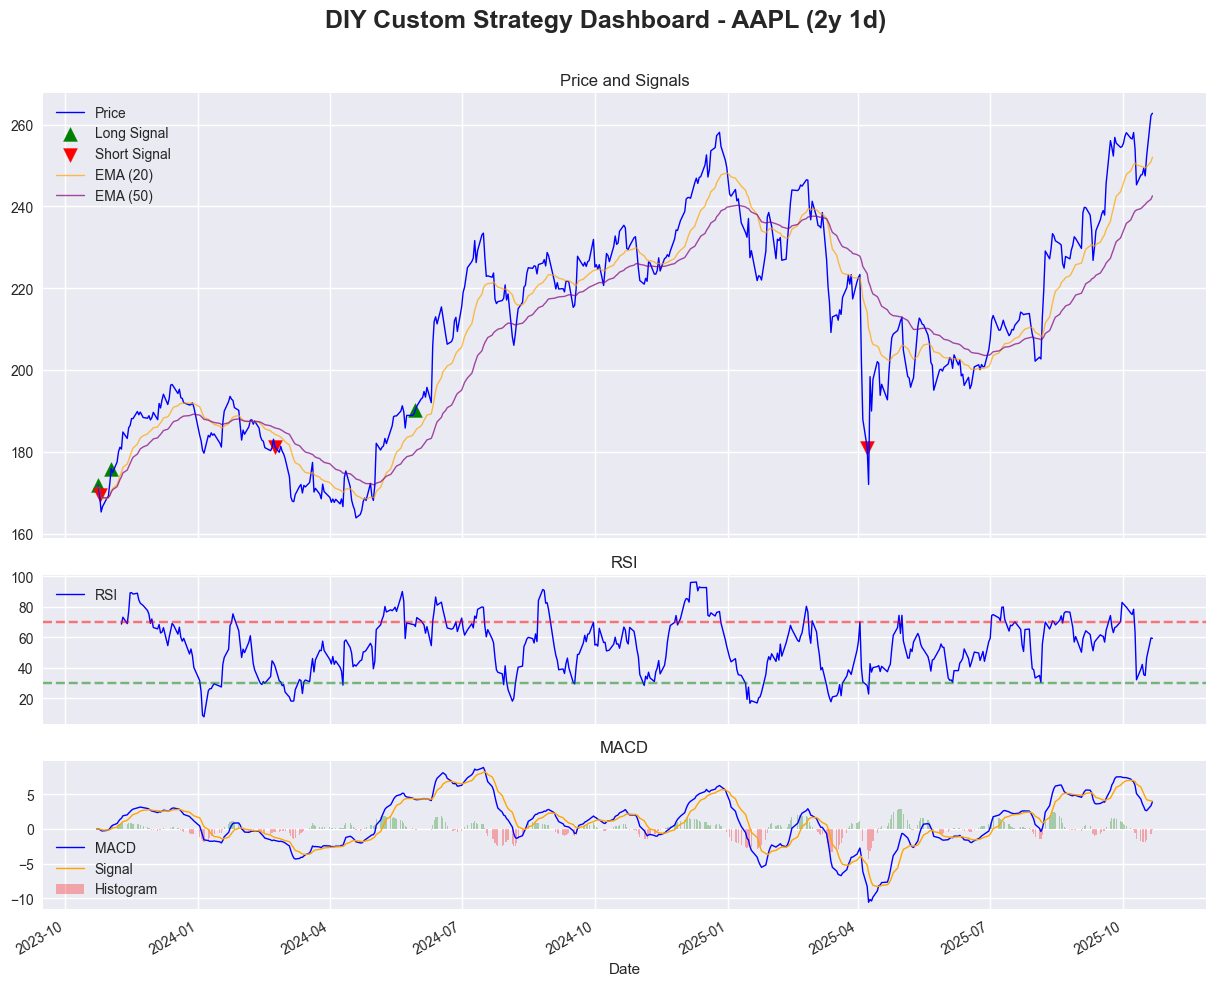


📋 Detailed Performance Summary:
No performance data available.

🎯 Recent Trading Signals:
   2023-10-25 - 🔴 SHORT at $169.44
   2023-11-02 - 🟢 LONG at $175.85
   2024-02-23 - 🔴 SHORT at $181.22
   2024-05-30 - 🟢 LONG at $190.18
   2025-04-07 - 🔴 SHORT at $181.02


In [12]:
# Create and display dashboard
if 'strategy' in locals() and df is not None:
    print("📊 Creating strategy dashboard...")
    
    # Calculate technical indicators
    print("📈 Calculating technical indicators...")
    # RSI
    df['rsi'] = TechnicalIndicators.rsi(df['close'], period=14)
    
    # MACD
    macd_line, signal_line, histogram = TechnicalIndicators.macd(df['close'])
    df['macd'] = macd_line
    df['macd_signal'] = signal_line
    df['macd_hist'] = histogram
    
    # EMAs
    df['ema_fast'] = TechnicalIndicators.ema(df['close'], period=20)
    df['ema_slow'] = TechnicalIndicators.ema(df['close'], period=50)

    # Use matplotlib for static dashboard
    print("📊 Using matplotlib for static dashboard...")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1], hspace=0.15)
    
    # Plot 1: Price and Signals
    ax1 = fig.add_subplot(gs[0])
    df['close'].plot(ax=ax1, label='Price', color='blue', linewidth=1)
    
    # Plot signals
    if hasattr(strategy, 'signals'):
        # Plot long signals
        long_signals = strategy.signals[strategy.signals['long_signal']].index
        ax1.scatter(long_signals, df.loc[long_signals, 'close'], 
                   marker='^', color='green', s=100, label='Long Signal')
        
        # Plot short signals
        short_signals = strategy.signals[strategy.signals['short_signal']].index
        ax1.scatter(short_signals, df.loc[short_signals, 'close'], 
                   marker='v', color='red', s=100, label='Short Signal')
    
    # Plot EMAs
    df['ema_fast'].plot(ax=ax1, label='EMA (20)', color='orange', alpha=0.7, linewidth=1)
    df['ema_slow'].plot(ax=ax1, label='EMA (50)', color='purple', alpha=0.7, linewidth=1)
    
    ax1.set_title('Price and Signals')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: RSI
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    df['rsi'].plot(ax=ax2, label='RSI', color='blue', linewidth=1)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_title('RSI')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: MACD
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    df['macd'].plot(ax=ax3, label='MACD', color='blue', linewidth=1)
    df['macd_signal'].plot(ax=ax3, label='Signal', color='orange', linewidth=1)
    ax3.bar(df.index, df['macd_hist'], 
            color=df['macd_hist'].apply(lambda x: 'g' if x > 0 else 'r'),
            alpha=0.3, label='Histogram')
    ax3.set_title('MACD')
    ax3.legend()
    ax3.grid(True)
    
    # Format x-axis
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    # Add title with symbol information
    fig.suptitle(f'DIY Custom Strategy Dashboard - {SYMBOL} ({PERIOD} {INTERVAL})', 
                 fontsize=18, fontweight='bold', y=0.95)

    plt.tight_layout()
    plt.show()

    # Print detailed performance summary
    print("\n📋 Detailed Performance Summary:")
    if hasattr(strategy, 'performance') and strategy.performance:
        perf = strategy.performance
        print("=" * 50)
        print("STRATEGY PERFORMANCE SUMMARY")
        print("=" * 50)
        print(f"Total Return: {perf.get('total_return', 0):.2f}%")
        print(f"Total Trades: {perf.get('total_trades', 0)}")
        print(f"Winning Trades: {perf.get('winning_trades', 0)}")
        print(f"Losing Trades: {perf.get('losing_trades', 0)}")
        print(f"Win Rate: {perf.get('win_rate', 0):.2f}%")
        print(f"Profit Factor: {perf.get('profit_factor', 0):.2f}")
        print(f"Gross Profit: ${perf.get('gross_profit', 0):.2f}")
        print(f"Gross Loss: ${perf.get('gross_loss', 0):.2f}")
        print(f"Sharpe Ratio: {perf.get('sharpe_ratio', 0):.2f}")
        print(f"Max Drawdown: {perf.get('max_drawdown', 0):.2f}%")
        print("=" * 50)
    else:
        print("No performance data available.")
    
    # Show recent signals if any
    if total_signals > 0:
        print(f"\n🎯 Recent Trading Signals:")
        recent_signals = strategy.signals[strategy.signals['long_signal'] | strategy.signals['short_signal']].tail(5)
        
        for idx, signal in recent_signals.iterrows():
            signal_type = "🟢 LONG" if signal['long_signal'] else "🔴 SHORT"
            price = df.loc[idx, 'close']
            print(f"   {idx.date()} - {signal_type} at ${price:.2f}")
            
else:
    print("❌ Cannot create dashboard without initialized strategy and data")

In [13]:
# Initialize and run StrategyDashboard
if 'df' in locals() and not df.empty:
    print("Creating Strategy Dashboard instance...")
    
    # Create strategy instance if not already created
    if 'strategy' not in locals():
        strategy = DIYCustomStrategy(df)
        print("Strategy instance created")
    
    # Calculate indicators and generate signals if not already done
    if not hasattr(strategy, 'signals') or strategy.signals is None:
        print("\nCalculating indicators and generating signals...")
        strategy.calculate_indicators()
        strategy.generate_signals()
    
    # Create dashboard instance
    dashboard = StrategyDashboard(strategy)
    
    # Run analysis and display results
    print("\nRunning Strategy Analysis...")
    
    # Display market state analysis
    print("\nMarket State Analysis:")
    if hasattr(dashboard, 'analyze_market_conditions'):
        dashboard.analyze_market_conditions()
    else:
        # Calculate basic market metrics
        returns = df['close'].pct_change()
        volatility = returns.std() * np.sqrt(252)  # Annualized volatility
        trend = 'Bullish' if df['close'].iloc[-1] > df['close'].rolling(50).mean().iloc[-1] else 'Bearish'
        
        print(f"Market Trend: {trend}")
        print(f"Volatility (Annualized): {volatility:.2%}")
        print(f"Current Price: ${df['close'].iloc[-1]:.2f}")
        print(f"50-day MA: ${df['close'].rolling(50).mean().iloc[-1]:.2f}")
    
    # Display signal analysis
    print("\nSignal Analysis:")
    if hasattr(strategy, 'signals'):
        long_signals = strategy.signals['long_signal'].sum()
        short_signals = strategy.signals['short_signal'].sum()
        total_signals = long_signals + short_signals
        
        print(f"Total Signals: {total_signals}")
        print(f"Long Signals: {long_signals}")
        print(f"Short Signals: {short_signals}")
        
        if total_signals > 0:
            print(f"Signal Distribution:")
            print(f"- Long: {long_signals/total_signals*100:.1f}%")
            print(f"- Short: {short_signals/total_signals*100:.1f}%")
    
    # Display risk metrics
    print("\nRisk Metrics:")
    returns = df['close'].pct_change().dropna()
    print(f"Max Drawdown: {(returns.min()*100):.2f}%")
    print(f"Daily Volatility: {(returns.std()*100):.2f}%")
    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    print(f"Sharpe Ratio: {sharpe:.2f}")
    
else:
    print("Cannot create dashboard without data. Please load data first.")

Creating Strategy Dashboard instance...

Running Strategy Analysis...

Market State Analysis:
Market Trend: Bullish
Volatility (Annualized): 28.12%
Current Price: $262.77
50-day MA: $242.44

Signal Analysis:
Total Signals: 6
Long Signals: 3
Short Signals: 3
Signal Distribution:
- Long: 50.0%
- Short: 50.0%

Risk Metrics:
Max Drawdown: -9.25%
Daily Volatility: 1.77%
Sharpe Ratio: 0.91


## Advanced Usage Examples

### 1. Analyze Different Stocks

Simply change the `SYMBOL` variable in cell 8 to analyze different stocks:

```python
# Popular stocks to analyze
SYMBOL = 'AAPL'  # Apple
SYMBOL = 'MSFT'  # Microsoft  
SYMBOL = 'GOOGL' # Google
SYMBOL = 'TSLA'  # Tesla
SYMBOL = 'NVDA'  # NVIDIA
SYMBOL = 'SPY'   # S&P 500 ETF
SYMBOL = 'QQQ'   # NASDAQ ETF
```

### 2. Different Leading Indicators

You can easily switch between different leading indicators:

```python
# Using Supertrend as leading indicator
strategy.settings['leading_indicator'] = 'Supertrend'
strategy.calculate_indicators()
strategy.generate_signals()

# Using Half Trend as leading indicator  
strategy.settings['leading_indicator'] = 'Half Trend'
strategy.calculate_indicators()
strategy.generate_signals()
```

### 3. Custom Risk Management

```python
# Enable trailing stop
strategy.settings.update({
    'use_trailing_stop': True,
    'trailing_stop_pct': 1.5,
    'stop_loss_pct': 2.5,
    'take_profit_pct': 5.0
})
```

### 4. Time-based Filtering

```python
# Only trade during market hours (9 AM to 4 PM)
strategy.settings.update({
    'use_time_filter': True,
    'start_hour': 9,
    'end_hour': 16
})
```

### 5. Position Sizing Options

```python
# Use fixed position size instead of percentage
strategy.settings.update({
    'use_fixed_size': True,
    'fixed_size': 100,  # 100 shares per trade
    'use_alternate': False  # Allow multiple positions
})
```

### 6. Multiple Confirmation Filters

```python
# Enable multiple confirmation indicators
strategy.settings.update({
    'respect_ema': True,
    'respect_rsi': True,
    'respect_macd': True,
    'respect_stochastic': True,
    'respect_vwap': True,
    'respect_volume': True
})
```

### 7. Different Time Periods

```python
# Analyze different time periods
PERIOD = '1y'    # 1 year
PERIOD = '2y'    # 2 years  
PERIOD = '5y'    # 5 years
PERIOD = 'max'   # All available data

# Different intervals
INTERVAL = '1d'  # Daily data
INTERVAL = '1h'  # Hourly data (for intraday)
INTERVAL = '1wk' # Weekly data
```


## Installation & Setup

### Required Packages

```bash
# Core dependencies
pip install yfinance pandas numpy matplotlib seaborn

# For interactive charts (recommended)
pip install lightweight-charts
```

### Optional Packages

```bash
# For enhanced plotting
pip install plotly

# For additional technical indicators
pip install ta-lib
```

### Dashboard Options

The notebook supports two dashboard types:

1. **Interactive Dashboard (Recommended)**: Uses `lightweight_charts`
   - Professional trading chart appearance
   - Zoom, pan, and crosshair functionality
   - Multiple synchronized subcharts
   - Real-time performance metrics
   - Export to HTML

2. **Static Dashboard**: Uses `matplotlib`
   - Multiple subplot layout
   - Comprehensive strategy overview
   - Good for reports and presentations

The notebook automatically detects which libraries are available and uses the best option.


In [14]:
# Quick Stock Comparison Function
def compare_stocks(symbols, period="1y", settings=None):
    """
    Compare multiple stocks with the same strategy settings
    
    Parameters:
    symbols (list): List of stock symbols to compare
    period (str): Time period for analysis
    settings (dict): Strategy settings (uses defaults if None)
    """
    if not YFINANCE_AVAILABLE:
        print("❌ yfinance not available for comparison")
        return
    
    results = {}
    
    for symbol in symbols:
        print(f"\n📊 Analyzing {symbol}...")
        
        # Fetch data
        data = fetch_stock_data(symbol, period=period, interval="1d")
        
        if data is not None:
            # Initialize strategy
            strategy = DIYCustomStrategy(data)
            
            # Apply custom settings if provided
            if settings:
                strategy.settings.update(settings)
            
            # Calculate indicators and signals
            strategy.calculate_indicators()
            strategy.generate_signals()
            
            # Run backtest
            backtest_engine = BacktestEngine(initial_capital=10000, commission=0.001)
            performance = backtest_engine.execute_backtest(strategy, data)
            
            # Store results
            if performance and performance['total_trades'] > 0:
                results[symbol] = {
                    'total_return': performance['total_return'],
                    'win_rate': performance['win_rate'],
                    'total_trades': performance['total_trades'],
                    'profit_factor': performance['profit_factor'],
                    'sharpe_ratio': performance['sharpe_ratio'],
                    'max_drawdown': performance['max_drawdown']
                }
                print(f"✅ {symbol}: {performance['total_return']:.2f}% return, {performance['win_rate']:.1f}% win rate")
            else:
                print(f"⚠️ {symbol}: No trades executed")
        else:
            print(f"❌ {symbol}: Failed to fetch data")
    
    # Display comparison table
    if results:
        print(f"\n📈 COMPARISON RESULTS ({period} period):")
        print("="*80)
        print(f"{'Symbol':<8} {'Return':<8} {'Win Rate':<10} {'Trades':<8} {'Profit Factor':<12} {'Sharpe':<8} {'Max DD':<8}")
        print("="*80)
        
        for symbol, metrics in results.items():
            print(f"{symbol:<8} {metrics['total_return']:>6.2f}% {metrics['win_rate']:>8.1f}% "
                  f"{metrics['total_trades']:>6} {metrics['profit_factor']:>10.2f} "
                  f"{metrics['sharpe_ratio']:>6.2f} {metrics['max_drawdown']:>6.2f}%")
        
        # Find best performers
        best_return = max(results.items(), key=lambda x: x[1]['total_return'])
        best_winrate = max(results.items(), key=lambda x: x[1]['win_rate'])
        best_sharpe = max(results.items(), key=lambda x: x[1]['sharpe_ratio'])
        
        print("\n🏆 Best Performers:")
        print(f"   Best Return: {best_return[0]} ({best_return[1]['total_return']:.2f}%)")
        print(f"   Best Win Rate: {best_winrate[0]} ({best_winrate[1]['win_rate']:.1f}%)")
        print(f"   Best Sharpe Ratio: {best_sharpe[0]} ({best_sharpe[1]['sharpe_ratio']:.2f})")
    
    return results

# Example usage - uncomment to run comparison
symbols_to_compare = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
comparison_results = compare_stocks(symbols_to_compare, period="1y")



📊 Analyzing AAPL...
📈 Fetching 1y of 1d data for AAPL...
✅ Successfully loaded 250 data points
📅 Date range: 2024-10-22 to 2025-10-21
💰 Price range: $172.00 - $262.77
All indicators calculated successfully!
Signals generated successfully!
✅ AAPL: -0.77% return, 31.6% win rate

📊 Analyzing MSFT...
📈 Fetching 1y of 1d data for MSFT...
✅ Successfully loaded 250 data points
📅 Date range: 2024-10-22 to 2025-10-21
💰 Price range: $353.33 - $534.76
All indicators calculated successfully!
Signals generated successfully!
✅ MSFT: -1.27% return, 22.2% win rate

📊 Analyzing GOOGL...
📈 Fetching 1y of 1d data for GOOGL...
✅ Successfully loaded 250 data points
📅 Date range: 2024-10-22 to 2025-10-21
💰 Price range: $144.40 - $256.55
All indicators calculated successfully!
Signals generated successfully!
✅ GOOGL: -1.00% return, 30.8% win rate

📊 Analyzing TSLA...
📈 Fetching 1y of 1d data for TSLA...
✅ Successfully loaded 250 data points
📅 Date range: 2024-10-22 to 2025-10-21
💰 Price range: $213.65 - $47

## Features Comparison with Pine Script

| Feature | Pine Script | Python Implementation | Status |
|---------|-------------|----------------------|---------|
| **Leading Indicators** | 30+ indicators | 10+ core indicators | ✅ Implemented |
| **Confirmation Filters** | 25+ filters | 15+ filters | ✅ Implemented |
| **Risk Management** | Stop Loss, Take Profit, Trailing Stop | All features | ✅ Implemented |
| **Position Sizing** | Fixed & Percentage | Both options | ✅ Implemented |
| **Time Filters** | Hour-based filtering | Hour-based filtering | ✅ Implemented |
| **Daily Trade Limits** | Max trades per day | Max trades per day | ✅ Implemented |
| **Signal Expiry** | Configurable expiry | Configurable expiry | ✅ Implemented |
| **Alternate Signals** | Long/Short alternation | Long/Short alternation | ✅ Implemented |
| **Data Source** | TradingView data | yfinance (real-time) | ✅ Enhanced |
| **Dashboard** | Real-time table display | Comprehensive plots | ✅ Enhanced |
| **Backtesting** | Built-in strategy tester | Custom backtest engine | ✅ Enhanced |
| **Performance Metrics** | Basic metrics | Extended metrics | ✅ Enhanced |
| **Multi-Stock Analysis** | Single symbol only | Multiple stocks comparison | ✅ New Feature |

## Key Improvements in Python Version

1. **Real Market Data**: Integration with yfinance for live stock data
2. **Enhanced Visualization**: Comprehensive dashboard with multiple charts
3. **Better Performance Analysis**: More detailed metrics including Sharpe ratio, max drawdown
4. **Flexible Configuration**: Easy to modify settings and test different combinations
5. **Multi-Stock Comparison**: Compare multiple stocks with the same strategy
6. **Extensible Design**: Easy to add new indicators and features
7. **Data Export**: Can export results to various formats
8. **Integration Ready**: Can be integrated with live trading systems

## Installation Requirements

```bash
pip install yfinance pandas numpy matplotlib seaborn
```

## Usage Instructions

1. **Change Stock Symbol**: Modify `SYMBOL` variable in cell 8
2. **Adjust Time Period**: Change `PERIOD` variable (1y, 2y, 5y, max)
3. **Configure Strategy**: Modify settings in cell 9
4. **Run Analysis**: Execute cells 8-12 in sequence
5. **Compare Stocks**: Use the `compare_stocks()` function for multiple stocks

## Notes

- This implementation focuses on the core functionality of the Pine Script
- Some advanced indicators from the original script may need additional implementation
- The signal generation logic closely matches the Pine Script behavior
- Risk management features are fully implemented
- The dashboard provides better visualization than the original Pine Script table
- Real market data integration makes it suitable for actual trading analysis
